In [1]:
# imports

# python packages
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.font_manager
import rpy2
from functools import reduce
import xarray as xr

# rpy2 imports
from rpy2 import robjects as ro
from rpy2.robjects.packages import importr
from rpy2.ipython.ggplot import image_png
from rpy2.robjects import pandas2ri

# load rpy2 extension for ipython
pandas2ri.activate()
%load_ext rpy2.ipython

# stop showing SettingWithCopyWarning
pd.options.mode.chained_assignment = None


/Users/blasks/Library/Caches/pypoetry/virtualenvs/barnacle-manuscript-4PSOCytX-py3.10/lib/python3.10/site-packages/rpy2/robjects/lib/ggplot2.py:70: UserWarning: This was designed againt ggplot2 versions starting with 3.3. but you have 3.5.0
  warnings.warn(


In [2]:
# install & import r package sctransform

# check if sctransform is installed
if not ro.packages.isinstalled('sctransform'):
    # select CRAN mirror
    utils = importr('utils')
    utils.chooseCRANmirror(ind=1)
    # install sctransform
    utils.install_packages(ro.vectors.StrVector(['sctransform']))
    
# check if glmGamPoi is installed
if not ro.packages.isinstalled('glmGamPoi'):
    print('Please install glmGamPoi: https://github.com/const-ae/glmGamPoi')

# import sctransform
sctransform = importr('sctransform')
rmatrix = importr('Matrix')

# should be version 0.4.1                          
print(sctransform.__version__)


0.4.1


In [3]:
# helper functions

# function to calculate 0-sensitive geometric mean
def geometric_mean(vector, pseudocount=1):
    return np.exp(np.mean(np.log(vector + pseudocount))) - pseudocount

# function to convert pandas dataframe to r matrix
def pandas_dataframe_to_r_matrix(df, dtype=float):
    """
    Function to convert pandas DataFrame objects to R matrix objects.
    """
    if dtype is float:
        vector = ro.vectors.FloatVector(df.values.flatten().tolist())
    elif dtype is str:
        vector = ro.vectors.StrVector(df.values.flatten().tolist())
    elif dtype is int:
        vector = ro.vectors.FloatVector(df.values.flatten().tolist())
    else:
        raise ValueError('The dtype {} is not recognized'.format(dtype))
    matrix = rmatrix.Matrix(
        data=vector, 
        nrow=df.shape[0], 
        ncol=df.shape[1], 
        byrow=True, 
        dimnames=[df.index.to_list(), df.columns.to_list()], 
        sparse=True
    )
    return matrix


# Read in collated mapping counts and metadata

In [4]:
# read in metadata

# filepaths
filepath_genome_metadata = '../../data/metadata/genome-metadata.csv'
filepath_ortholog_metadata = '../../data/metadata/ortholog-metadata.csv'
filepath_sample_metadata = '../../data/metadata/sample-metadata.csv'

# genome metadata
genome_df = pd.read_csv(filepath_genome_metadata)
genome_df.loc[genome_df['Group'] == 'Uncultured-marine-virus', 'Group'] = 'Virus'
genome_df.loc[genome_df['Virocell'], 'Group'] = 'Virocell'

#  ortholog metadata
ortholog_df = pd.read_csv(filepath_ortholog_metadata)

#  sample metadata
sample_df = pd.read_csv(filepath_sample_metadata)
sample_df['Cruise'] = sample_df['Cruise'].map({'kok1606': 'G1', 
                                               'mgl1704': 'G2', 
                                               'km1906': 'G3'})
sample_df['SampleName'] = [name[:-2] for name in sample_df['SampleID']]

# create annotations_df to map annotations back to orthologs
annotations_df = ortholog_df[['CyCOGID', 'Annotation']].drop_duplicates()

# directory to store output
output_dir = '../../data/3-normalization'

sample_df


,SampleID,Cruise,Dataset,Experiment,Station,Cast,Datetime,Latitude,Longitude,Depth,Replicate,SmallFraction,LargeFraction,Unfractionated,Batch,SampleName
0,G1.SURF.NS.S02C1.15m.A,G1,Gradients 1 surface,NaN,2.0,1.0,4/20/16 5:51,23.495833,-157.994333,15,A,G1.SURF.NS.S02C1.15m.0_2um.A,G1.SURF.NS.S02C1.15m.3um.A,False,G1_SURF,G1.SURF.NS.S02C1.15m
1,G1.SURF.NS.S02C1.15m.B,G1,Gradients 1 surface,NaN,2.0,1.0,4/20/16 5:51,23.495833,-157.994333,15,B,G1.SURF.NS.S02C1.15m.0_2um.B,G1.SURF.NS.S02C1.15m.3um.B,False,G1_SURF,G1.SURF.NS.S02C1.15m
2,G1.SURF.NS.S02C1.15m.C,G1,Gradients 1 surface,NaN,2.0,1.0,4/20/16 5:51,23.495833,-157.994333,15,C,G1.SURF.NS.S02C1.15m.0_2um.C,G1.SURF.NS.S02C1.15m.3um.C,False,G1_SURF,G1.SURF.NS.S02C1.15m
3,G1.SURF.NS.S04C1.15m.A,G1,Gradients 1 surface,NaN,4.0,1.0,4/22/16 5:40,28.143167,-158.000667,15,A,G1.SURF.NS.S04C1.15m.0_2um.A,G1.SURF.NS.S04C1.15m.3um.A,False,G1_SURF,G1.SURF.NS.S04C1.15m
4,G1.SURF.NS.S04C1.15m.B,G1,Gradients 1 surface,NaN,4.0,1.0,4/22/16 5:40,28.143167,-158.000667,15,B,G1.SURF.NS.S04C1.15m.0_2um.B,G1.SURF.NS.S04C1.15m.3um.B,False,G1_SURF,G1.SURF.NS.S04C1.15m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,G3.UW.NS.UW40_1.7m.B,G3,Gradients 3 underway,NaN,NaN,NaN,4/24/19 5:57,40.880000,-158.000000,7,B,G3.UW.NS.UW40_1.7m.0_2um.B,G3.UW.NS.UW40_1.7m.3um.B,False,G3_SURF,G3.UW.NS.UW40_1.7m
218,G3.UW.NS.UW40_1.7m.C,G3,Gradients 3 underway,NaN,NaN,NaN,4/24/19 5:57,40.880000,-158.000000,7,C,G3.UW.NS.UW40_1.7m.0_2um.C,G3.UW.NS.UW40_1.7m.3um.C,False,G3_SURF,G3.UW.NS.UW40_1.7m
219,G3.UW.NS.UW40_2.7m.A,G3,Gradients 3 underway,NaN,NaN,NaN,4/25/19 6:01,40.090000,-158.000000,7,A,G3.UW.NS.UW40_2.7m.0_2um.A,G3.UW.NS.UW40_2.7m.3um.A,False,G3_SURF,G3.UW.NS.UW40_2.7m
220,G3.UW.NS.UW40_2.7m.B,G3,Gradients 3 underway,NaN,NaN,NaN,4/25/19 6:01,40.090000,-158.000000,7,B,G3.UW.NS.UW40_2.7m.0_2um.B,G3.UW.NS.UW40_2.7m.3um.B,False,G3_SURF,G3.UW.NS.UW40_2.7m


In [5]:
# read in mapped transcript abundance data

filepath_data = '../../data/2-mapping/collated_salmon_data.csv.gz'
mappings_df = pd.read_csv(filepath_data)
mappings_df


,MappingName,GeneLength,TPM,NumReads,SampleID,GenomeName,GeneID
0,AG-316-L16_2717627218,1116,0.0,0.0,G3.DIEL.NS.S4C21.15m.A,AG-316-L16,2717627218
1,AG-316-L16_2717627219,1290,0.0,0.0,G3.DIEL.NS.S4C21.15m.A,AG-316-L16,2717627219
2,AG-316-L16_2717627220,1578,0.0,0.0,G3.DIEL.NS.S4C21.15m.A,AG-316-L16,2717627220
3,AG-316-L16_2717627221,99,0.0,0.0,G3.DIEL.NS.S4C21.15m.A,AG-316-L16,2717627221
4,AG-316-L16_2717627222,1050,0.0,0.0,G3.DIEL.NS.S4C21.15m.A,AG-316-L16,2717627222
...,...,...,...,...,...,...,...
219859471,Syn9_638323192,228,0.0,0.0,G3.DIEL.NS.S4C13.15m.B,Syn9,638323192
219859472,Syn9_638323193,711,0.0,0.0,G3.DIEL.NS.S4C13.15m.B,Syn9,638323193
219859473,Syn9_638323194,180,0.0,0.0,G3.DIEL.NS.S4C13.15m.B,Syn9,638323194
219859474,Syn9_638323195,231,0.0,0.0,G3.DIEL.NS.S4C13.15m.B,Syn9,638323195


# Process mapped reads

- Drop reference genes without ortholog mapping (mostly non-coding RNA)
- Within each clade in each sample, aggregate reads mapping to the same ortholog


In [6]:
# look at read mappings per group and clade

pangenome_df = mappings_df[['MappingName', 'SampleID', 'GenomeName', 'NumReads']]

# add genus, clade, and ortholog info to dataframe
pangenome_df['Group'] = pangenome_df['GenomeName'].map(genome_df.set_index('GenomeName')['Group'])
pangenome_df['Clade'] = pangenome_df['GenomeName'].map(genome_df.set_index('GenomeName')['Clade'])
pangenome_df['CyCOGID'] = pangenome_df['MappingName'].map(ortholog_df.set_index('MappingName')['CyCOGID'])

# down-select to only mappings that don't belong to a virus or virocell reference
drop_references = genome_df[genome_df['Group'].isin(['Virus', 'Virocell'])].GenomeName.to_list()
pangenome_df = pangenome_df[~pangenome_df.GenomeName.isin(drop_references)]

# down-select to only the genes with an ortholog mapping
pangenome_df = pangenome_df[~pangenome_df['CyCOGID'].isna()]

# aggregate all orthologs in same clade
pangenome_df = pangenome_df.groupby(['SampleID', 'Group', 'Clade', 'CyCOGID']).agg(Reads=('NumReads', 'sum')).reset_index()

# identify nonzero mappings (at least one read mapped to ortholog-sample-clade)
pangenome_df['Nonzero'] = pangenome_df['Reads'].gt(0.0)

pangenome_df


,SampleID,Group,Clade,CyCOGID,Reads,Nonzero
0,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,AMZ-II,60000002.0,0.0,False
1,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,AMZ-II,60000003.0,0.0,False
2,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,AMZ-II,60000004.0,0.0,False
3,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,AMZ-II,60000005.0,0.0,False
4,G1.SURF.NS.S02C1.15m.A,Prochlorococcus,AMZ-II,60000006.0,0.0,False
...,...,...,...,...,...,...
21899629,G3.UW.NS.UW40_2.7m.C,Synechococcus,Unclassified,60039505.0,0.0,False
21899630,G3.UW.NS.UW40_2.7m.C,Synechococcus,Unclassified,60039506.0,1.0,True
21899631,G3.UW.NS.UW40_2.7m.C,Synechococcus,Unclassified,60039507.0,0.0,False
21899632,G3.UW.NS.UW40_2.7m.C,Synechococcus,Unclassified,60039508.0,0.0,False


# Separate out data by clade

In [7]:
# separate out data for most highly represented clades in dataset

# thresholds
detection_min = 3 # minimum number of samples a CyCOG must be detected in for each ecotype
coverage_threshold = 0.01 # minimum proportion of detected CyCOGs required for each sample to be included in data subset
clades = {
    'pro': ['HLI', 'HLII', 'LLI'], 
    'syn': ['5.1A-CRD2', '5.1A-II', '5.1A-III', '5.1A-IV', '5.1A-UC-A-EnvC', '5.1B-CRD1', '5.1B-I']
}

# storage variables
ortho_list = []
sample_list = []
core_df_dict = {}

for selected_clade in clades['pro'] + clades['syn']:
    print(selected_clade)
    clade_pangenome_df = pangenome_df[pangenome_df.Clade == selected_clade]
    clade_pangenome_df['Batch'] = clade_pangenome_df['SampleID'].map(sample_df.set_index('SampleID')['Batch'])

    # make fresh directory
    dir_path = '{}/{}'.format(output_dir, selected_clade)
    if not os.path.isdir(dir_path):
        os.makedirs(dir_path)
    
    # down-select data to detected orthologs
    core_df = pd.DataFrame(clade_pangenome_df.groupby('CyCOGID').Nonzero.sum())
    core_df = core_df[core_df.Nonzero.gt(0)] # all detected CyCOGs
    clade_pangenome_df = clade_pangenome_df[clade_pangenome_df.CyCOGID.isin(core_df.index)]

    # down-select to only samples with coverage that is at least x% of the max coverage found in the dataset
    coverage = clade_pangenome_df.groupby('SampleID').Nonzero.sum()
    max_cov = coverage.max()
    total_orthos = len(core_df.index)
    print('Max coverage: {} / {} orthologs ({})'.format(max_cov, total_orthos, max_cov/total_orthos))
    samples = coverage[coverage.gt(coverage.max() * coverage_threshold)].index
    sample_list.append(samples)
    min_cov = coverage[samples].min()
    print('Min coverage: {} / {} orthologs ({})'.format(min_cov, total_orthos, min_cov/total_orthos))
    print('Total samples: {}\n'.format(len(samples)))
    clade_pangenome_df = clade_pangenome_df[clade_pangenome_df['SampleID'].isin(samples)]
    
    # down-select data to only orthologs that show up in a minimum number of samples in at least one batch
    core_df = pd.DataFrame(clade_pangenome_df.groupby(
        ['CyCOGID', 'Batch']).Nonzero.sum().ge(detection_min).groupby('CyCOGID').sum())
    core_df = core_df[core_df.Nonzero.gt(0)]
    clade_pangenome_df = clade_pangenome_df[clade_pangenome_df.CyCOGID.isin(core_df.index)]
    ortho_list.append(core_df.index)

    # pivot table
    clade_core_df = clade_pangenome_df.pivot(index='CyCOGID', columns=['SampleID'], values='Reads')
    core_df_dict[selected_clade] = clade_core_df
    
    # save pre-normed data to csv
    clade_core_df.to_csv('{}/read_counts_{}.csv'.format(dir_path, selected_clade))
    

HLI
Max coverage: 2818 / 3906 orthologs (0.7214541730670763)
Min coverage: 29 / 3906 orthologs (0.007424475166410651)
Total samples: 172

HLII
Max coverage: 3446 / 4787 orthologs (0.7198663045748903)
Min coverage: 42 / 4787 orthologs (0.008773762272822228)
Total samples: 131

LLI
Max coverage: 2966 / 3452 orthologs (0.8592120509849362)
Min coverage: 30 / 3452 orthologs (0.00869061413673233)
Total samples: 131

5.1A-CRD2
Max coverage: 2785 / 3303 orthologs (0.8431728731456252)
Min coverage: 28 / 3303 orthologs (0.008477141992128368)
Total samples: 144

5.1A-II
Max coverage: 2840 / 3338 orthologs (0.8508088675853804)
Min coverage: 29 / 3338 orthologs (0.008687837028160575)
Total samples: 131

5.1A-III
Max coverage: 1868 / 2464 orthologs (0.7581168831168831)
Min coverage: 19 / 2464 orthologs (0.007711038961038961)
Total samples: 124

5.1A-IV
Max coverage: 3063 / 3390 orthologs (0.9035398230088496)
Min coverage: 32 / 3390 orthologs (0.00943952802359882)
Total samples: 207

5.1A-UC-A-EnvC
M

In [8]:
# look at intersections of samples and genes

# universal
print('Total cyanobacterial orthologs: {}'.format(len(reduce(np.union1d, ortho_list))))
print('Total cyanobacterial samples: {}'.format(len(reduce(np.union1d, sample_list))))
print('Shared cyanobacterial orthologs: {}'.format(len(reduce(np.intersect1d, ortho_list))))
print('Shared cyanobacterial samples: {}\n'.format(len(reduce(np.intersect1d, sample_list))))

# pro
print('Total Pro orthologs: {}'.format(len(reduce(np.union1d, ortho_list[:3]))))
print('Total Pro samples: {}'.format(len(reduce(np.union1d, sample_list[:3]))))
print('Shared Pro orthologs: {}'.format(len(reduce(np.intersect1d, ortho_list[:3]))))
print('Shared Pro samples: {}\n'.format(len(reduce(np.intersect1d, sample_list[:3]))))

# syn
print('Total Syn orthologs: {}'.format(len(reduce(np.union1d, ortho_list[3:]))))
print('Total Syn samples: {}'.format(len(reduce(np.union1d, sample_list[3:]))))
print('Shared Syn orthologs: {}'.format(len(reduce(np.intersect1d, ortho_list[3:]))))
print('Shared Syn samples: {}\n'.format(len(reduce(np.intersect1d, sample_list[3:]))))


Total cyanobacterial orthologs: 9553
Total cyanobacterial samples: 222
Shared cyanobacterial orthologs: 1195
Shared cyanobacterial samples: 94

Total Pro orthologs: 5023
Total Pro samples: 175
Shared Pro orthologs: 1714
Shared Pro samples: 118

Total Syn orthologs: 6478
Total Syn samples: 222
Shared Syn orthologs: 1556
Shared Syn samples: 103



In [9]:
# count samples in each batch for each clade

batch_samples = {b: sample_df[sample_df['Batch'] == b]['SampleID'].tolist() for b in sample_df['Batch'].unique()}
for genus in ['pro', 'syn']:
    for clade in clades[genus]:
        print('\n{}'.format(clade))
        clade_core_df = core_df_dict[clade]
        for batch in sample_df['Batch'].unique():
            samples = [s for s in batch_samples[batch] if s in clade_core_df.columns]
            batch_df = clade_core_df[samples]
            print('\t{}: {} samples'.format(batch, batch_df.shape[1]))
            


HLI
	G1_SURF: 22 samples
	BEXP: 24 samples
	RR_DCM: 33 samples
	G2_SURF: 30 samples
	DEPTH_DIEL: 38 samples
	G3_SURF: 25 samples

HLII
	G1_SURF: 20 samples
	BEXP: 24 samples
	RR_DCM: 32 samples
	G2_SURF: 26 samples
	DEPTH_DIEL: 10 samples
	G3_SURF: 19 samples

LLI
	G1_SURF: 22 samples
	BEXP: 19 samples
	RR_DCM: 27 samples
	G2_SURF: 27 samples
	DEPTH_DIEL: 11 samples
	G3_SURF: 25 samples

5.1A-CRD2
	G1_SURF: 22 samples
	BEXP: 24 samples
	RR_DCM: 33 samples
	G2_SURF: 29 samples
	DEPTH_DIEL: 11 samples
	G3_SURF: 25 samples

5.1A-II
	G1_SURF: 21 samples
	BEXP: 24 samples
	RR_DCM: 32 samples
	G2_SURF: 25 samples
	DEPTH_DIEL: 9 samples
	G3_SURF: 20 samples

5.1A-III
	G1_SURF: 19 samples
	BEXP: 24 samples
	RR_DCM: 29 samples
	G2_SURF: 24 samples
	DEPTH_DIEL: 9 samples
	G3_SURF: 19 samples

5.1A-IV
	G1_SURF: 18 samples
	BEXP: 25 samples
	RR_DCM: 43 samples
	G2_SURF: 30 samples
	DEPTH_DIEL: 66 samples
	G3_SURF: 25 samples

5.1A-UC-A-EnvC
	G1_SURF: 19 samples
	BEXP: 24 samples
	RR_DCM: 30 sampl

# Normalize data using sctransform

* Save diagnostic plots & csv files, as well as tensorized data in NetCDF4 format

pro
HLI


R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 3109

R[write to console]: Total overdispersed genes: 3021

R[write to console]: Excluding 88 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 3109 by 172

R[write to console]: Model formula is y ~ (log_umi) : Batch + Batch + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 172 cells



  |======================================================================| 100%


R[write to console]: Setting estimate of  9 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 353 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch G1_SURF -- assuming a low mean.

R[write to console]: Some genes not detected in batch BEXP -- assuming a low mean.

R[write to console]: Some genes not detected in batch RR_DCM -- assuming a low mean.

R[write to console]: Some genes not detected in batch G2_SURF -- assuming a low mean.

R[write to console]: Some genes not detected in batch DEPTH_DIEL -- assuming a low mean.

R[write to console]: Some genes not detected in batch G3_SURF -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  6.75792016

R[write to console]: Second step: Get residuals using fitted parameters for 3109 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 8.172152 secs



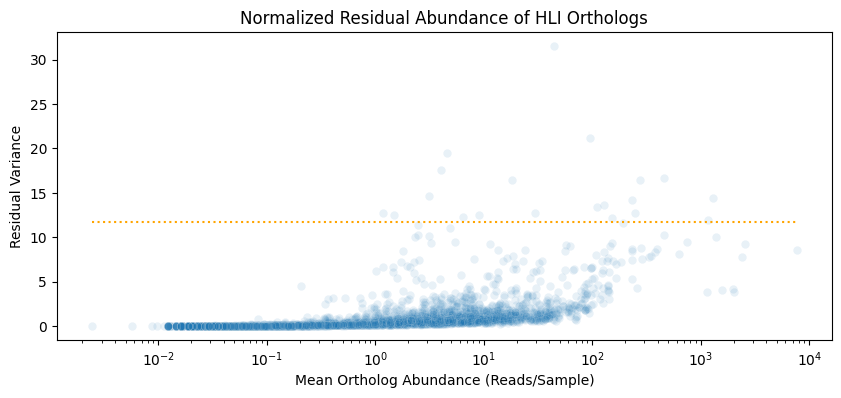

R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 3540

R[write to console]: Total overdispersed genes: 3414

R[write to console]: Excluding 126 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 3540 by 131

R[write to console]: Model formula is y ~ (log_umi) : Batch + Batch + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 131 cells



HLII
  |======================================================================| 100%


R[write to console]: Setting estimate of  31 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 782 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch G1_SURF -- assuming a low mean.

R[write to console]: Some genes not detected in batch BEXP -- assuming a low mean.

R[write to console]: Some genes not detected in batch RR_DCM -- assuming a low mean.

R[write to console]: Some genes not detected in batch G2_SURF -- assuming a low mean.

R[write to console]: Some genes not detected in batch DEPTH_DIEL -- assuming a low mean.

R[write to console]: Some genes not detected in batch G3_SURF -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  3.24216036

R[write to console]: Second step: Get residuals using fitted parameters for 3540 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 6.235323 secs

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: The `guide` argument in `scale_*()` cannot be `FALSE`. This was deprecated in
ggplot2 3.3.4.
ℹ Please use "none" instead.
ℹ The deprecated feature was likely used in the sctransform package.
  Please report the issue at <https://github.com/satijalab/sctransform/issues>.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 



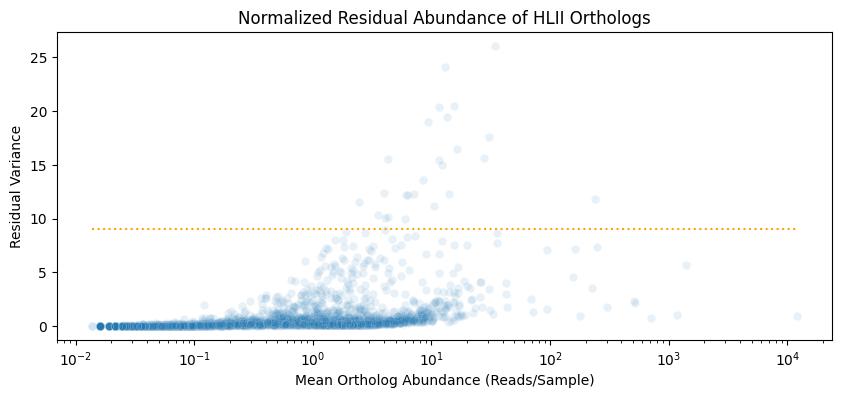

R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2655

R[write to console]: Total overdispersed genes: 2613

R[write to console]: Excluding 42 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2655 by 131

R[write to console]: Model formula is y ~ (log_umi) : Batch + Batch + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 131 cells



LLI
  |======================================================================| 100%


R[write to console]: Setting estimate of  6 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 690 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch G1_SURF -- assuming a low mean.

R[write to console]: Some genes not detected in batch BEXP -- assuming a low mean.

R[write to console]: Some genes not detected in batch RR_DCM -- assuming a low mean.

R[write to console]: Some genes not detected in batch G2_SURF -- assuming a low mean.

R[write to console]: Some genes not detected in batch DEPTH_DIEL -- assuming a low mean.

R[write to console]: Some genes not detected in batch G3_SURF -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1.44

R[write to console]: Second step: Get residuals using fitted parameters for 2655 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 6.555955 secs



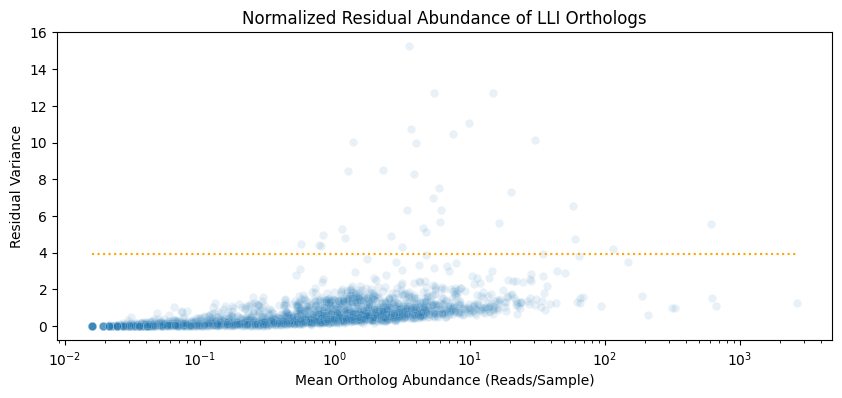

R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2951

R[write to console]: Total overdispersed genes: 2906

R[write to console]: Excluding 45 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2951 by 144

R[write to console]: Model formula is y ~ (log_umi) : Batch + Batch + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 144 cells



syn
5.1A-CRD2
  |======================================================================| 100%


R[write to console]: Setting estimate of  9 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 385 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch G1_SURF -- assuming a low mean.

R[write to console]: Some genes not detected in batch BEXP -- assuming a low mean.

R[write to console]: Some genes not detected in batch RR_DCM -- assuming a low mean.

R[write to console]: Some genes not detected in batch DEPTH_DIEL -- assuming a low mean.

R[write to console]: Some genes not detected in batch G3_SURF -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1

R[write to console]: Second step: Get residuals using fitted parameters for 2951 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 5.647794 secs



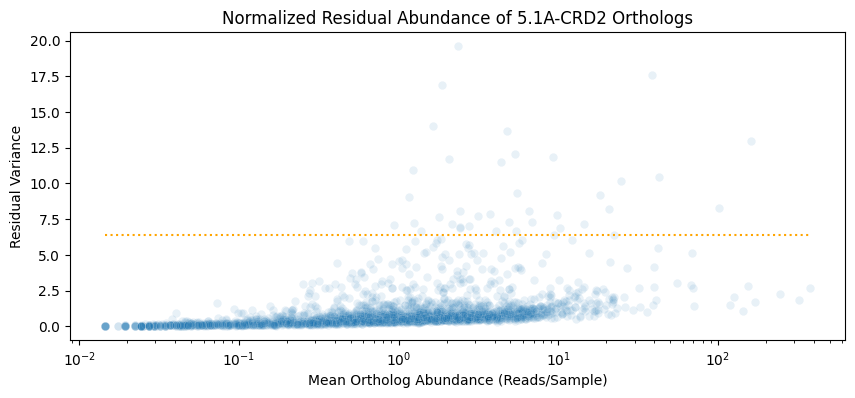

R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2948

R[write to console]: Total overdispersed genes: 2899

R[write to console]: Excluding 49 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2948 by 131

R[write to console]: Model formula is y ~ (log_umi) : Batch + Batch + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 131 cells



5.1A-II
  |======================================================================| 100%


R[write to console]: Setting estimate of  13 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 798 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch G1_SURF -- assuming a low mean.

R[write to console]: Some genes not detected in batch BEXP -- assuming a low mean.

R[write to console]: Some genes not detected in batch RR_DCM -- assuming a low mean.

R[write to console]: Some genes not detected in batch G2_SURF -- assuming a low mean.

R[write to console]: Some genes not detected in batch DEPTH_DIEL -- assuming a low mean.

R[write to console]: Some genes not detected in batch G3_SURF -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1.44

R[write to console]: Second step: Get residuals using fitted parameters for 2948 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 6.096645 secs



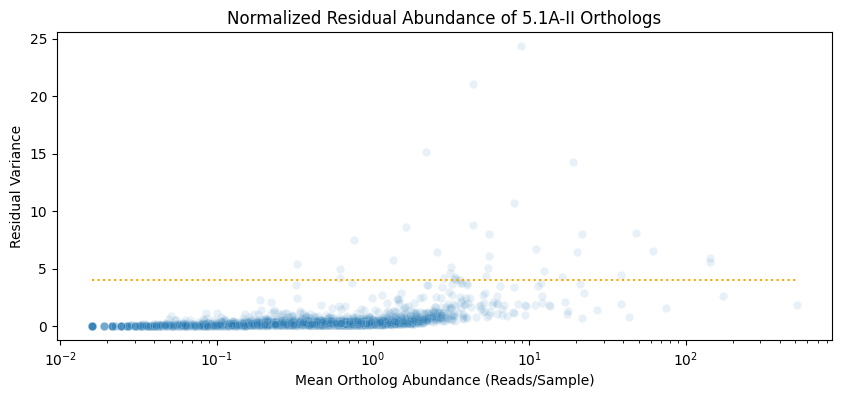

R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2045

R[write to console]: Total overdispersed genes: 2005

R[write to console]: Excluding 40 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2045 by 124

R[write to console]: Model formula is y ~ (log_umi) : Batch + Batch + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 124 cells



5.1A-III
  |======================================================================| 100%


R[write to console]: Setting estimate of  5 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 747 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch G1_SURF -- assuming a low mean.

R[write to console]: Some genes not detected in batch BEXP -- assuming a low mean.

R[write to console]: Some genes not detected in batch RR_DCM -- assuming a low mean.

R[write to console]: Some genes not detected in batch G2_SURF -- assuming a low mean.

R[write to console]: Some genes not detected in batch DEPTH_DIEL -- assuming a low mean.

R[write to console]: Some genes not detected in batch G3_SURF -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 2045 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 5.300639 secs



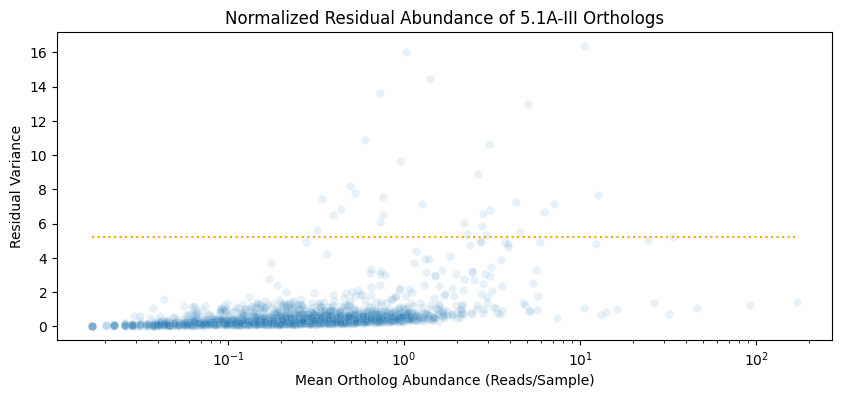

R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 3121

R[write to console]: Total overdispersed genes: 3095

R[write to console]: Excluding 26 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 3121 by 207

R[write to console]: Model formula is y ~ (log_umi) : Batch + Batch + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 207 cells



5.1A-IV
  |======================================================================| 100%


R[write to console]: Setting estimate of  16 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 329 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch G1_SURF -- assuming a low mean.

R[write to console]: Some genes not detected in batch BEXP -- assuming a low mean.

R[write to console]: Some genes not detected in batch RR_DCM -- assuming a low mean.

R[write to console]: Some genes not detected in batch DEPTH_DIEL -- assuming a low mean.

R[write to console]: Some genes not detected in batch G3_SURF -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1.44048004

R[write to console]: Second step: Get residuals using fitted parameters for 3121 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 7.519169 secs



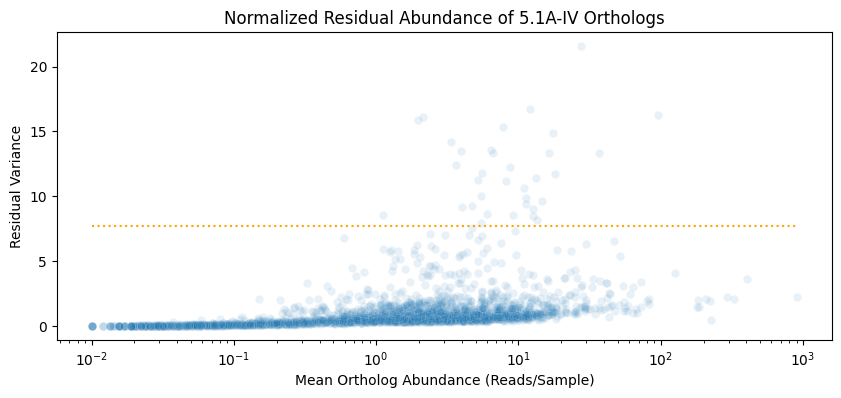

R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2517

R[write to console]: Total overdispersed genes: 2490

R[write to console]: Excluding 27 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2517 by 124

R[write to console]: Model formula is y ~ (log_umi) : Batch + Batch + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 124 cells



5.1A-UC-A-EnvC
  |======================================================================| 100%


R[write to console]: Setting estimate of  24 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 859 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch G1_SURF -- assuming a low mean.

R[write to console]: Some genes not detected in batch BEXP -- assuming a low mean.

R[write to console]: Some genes not detected in batch RR_DCM -- assuming a low mean.

R[write to console]: Some genes not detected in batch G2_SURF -- assuming a low mean.

R[write to console]: Some genes not detected in batch DEPTH_DIEL -- assuming a low mean.

R[write to console]: Some genes not detected in batch G3_SURF -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 2517 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 5.497391 secs



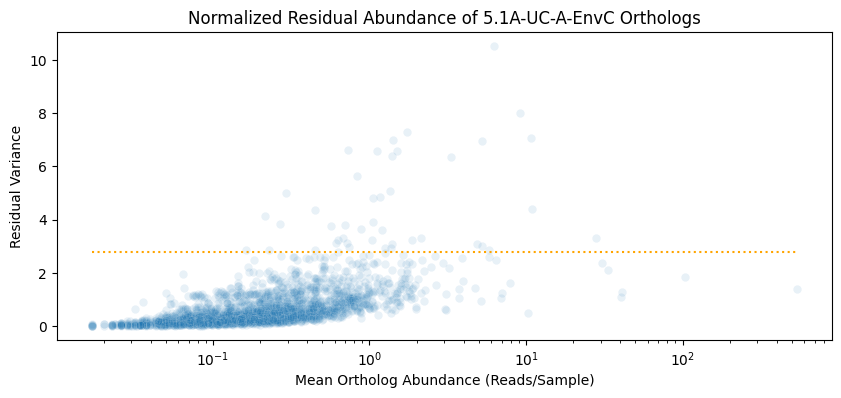

R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 3574

R[write to console]: Total overdispersed genes: 3523

R[write to console]: Excluding 51 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 3574 by 152

R[write to console]: Model formula is y ~ (log_umi) : Batch + Batch + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 152 cells



5.1B-CRD1
  |======================================================================| 100%


R[write to console]: Setting estimate of  27 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 523 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch G1_SURF -- assuming a low mean.

R[write to console]: Some genes not detected in batch BEXP -- assuming a low mean.

R[write to console]: Some genes not detected in batch RR_DCM -- assuming a low mean.

R[write to console]: Some genes not detected in batch DEPTH_DIEL -- assuming a low mean.

R[write to console]: Some genes not detected in batch G3_SURF -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  1

R[write to console]: Second step: Get residuals using fitted parameters for 3574 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 6.084541 secs



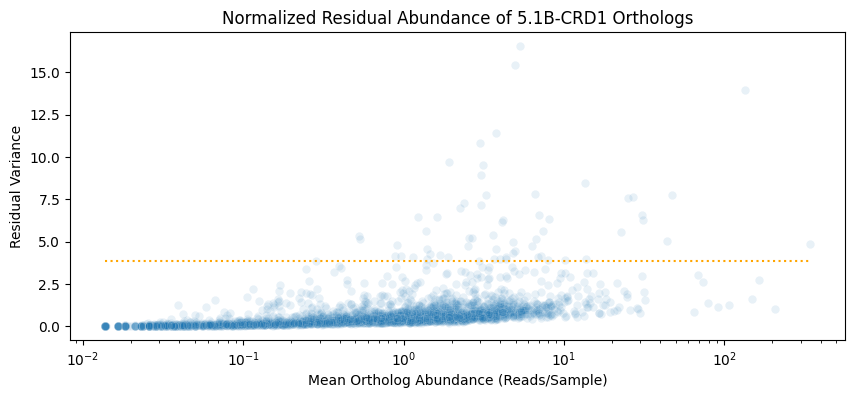

R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Total Step 1 genes: 2932

R[write to console]: Total overdispersed genes: 2887

R[write to console]: Excluding 45 genes from Step 1 because they are not overdispersed.

R[write to console]: Variance stabilizing transformation of count matrix of size 2932 by 203

R[write to console]: Model formula is y ~ (log_umi) : Batch + Batch + 0

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 203 cells



5.1B-I
  |======================================================================| 100%


R[write to console]: Setting estimate of  11 genes to inf as theta_mm/theta_mle < 1e-3

R[write to console]: Found 529 outliers - those will be ignored in fitting/regularization step


R[write to console]: Some genes not detected in batch G1_SURF -- assuming a low mean.

R[write to console]: Some genes not detected in batch BEXP -- assuming a low mean.

R[write to console]: Some genes not detected in batch RR_DCM -- assuming a low mean.

R[write to console]: Some genes not detected in batch G2_SURF -- assuming a low mean.

R[write to console]: Some genes not detected in batch DEPTH_DIEL -- assuming a low mean.

R[write to console]: Some genes not detected in batch G3_SURF -- assuming a low mean.

R[write to console]: Setting min_variance based on median UMI:  0.36

R[write to console]: Second step: Get residuals using fitted parameters for 2932 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 6.464597 secs



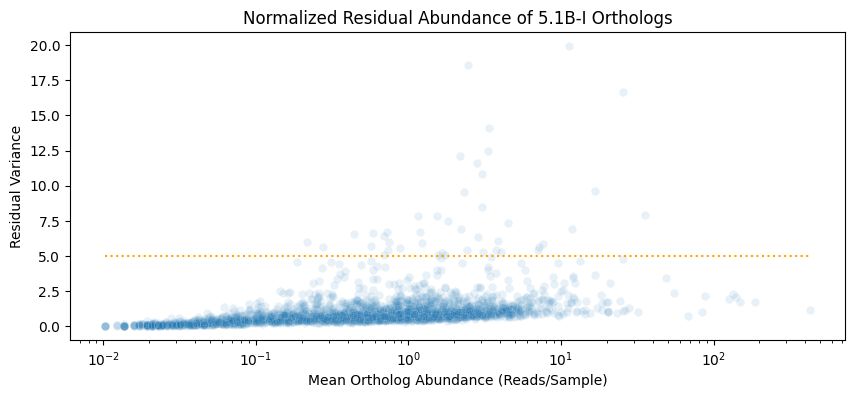

In [10]:
# run the model on each clade, use dataset as covariate to regress out

# store normalized data as slabs to arrange in xarray tensor
read_slabs = {}
residual_slabs = {}

# iterate through pro & syn
for genus in ['pro', 'syn']:
    print(genus)
    read_slabs[genus] = []
    residual_slabs[genus] = []
        
    # iterate through clades
    for clade in clades[genus]:
        print(clade)
        clade_core_df = core_df_dict[clade]
        r_clade_core_df = pandas_dataframe_to_r_matrix(clade_core_df)
        # pull out sample attributes
        sample_attr_df = sample_df.set_index('SampleID').loc[clade_core_df.columns, ['Dataset', 'Cruise', 'Batch']]
        r_sample_attr_df = pandas2ri.py2rpy(sample_attr_df)

        # make fresh directory
        dir_path = '{}/{}'.format(output_dir, clade)
        if not os.path.isdir(dir_path):
            os.makedirs(dir_path)

        # fit vst normalization model
        result = sctransform.vst(
            r_clade_core_df, 
            cell_attr=r_sample_attr_df, 
            batch_var=ro.vectors.StrVector(["Batch"]),
            min_cells=detection_min,
            return_gene_attr=True, 
            return_cell_attr=True, 
            vst_flavor='v2', 
            verbosity=10
        )

        # save plot of model parameters
        plots = sctransform.plot_model_pars(result, show_theta=True)
        img = image_png(plots)
        with open('{}/parameters_{}.png'.format(dir_path, clade), 'wb') as png:
            png.write(img.data)

        # convert residuals result to a dataframe
        residual_df = pd.DataFrame(
            np.asarray(result[0]), 
            index=clade_core_df.index, 
            columns=clade_core_df.columns
        )

        # save residuals as csv
        residual_df.to_csv('{}/residuals_{}.csv'.format(dir_path, clade))
        
        # save residuals as slab 
        slab = (
            residual_df
            .reset_index()
            .rename(columns={'CyCOGID': 'Ortholog'})
            .melt(id_vars='Ortholog', var_name='Sample', value_name='Residual')
        )
        slab['Ortholog'] = slab['Ortholog'].astype('Int64')
        slab['Clade'] = clade
        residual_slabs[genus].append(slab.set_index(['Ortholog', 'Clade', 'Sample']))
        
        # save read counts as slab 
        slab = (
            clade_core_df
            .reset_index()
            .rename(columns={'CyCOGID': 'Ortholog'})
            .melt(id_vars='Ortholog', var_name='Sample', value_name='ReadCount')
        )
        slab['Ortholog'] = slab['Ortholog'].astype('Int64')
        slab['Clade'] = clade
        read_slabs[genus].append(slab.set_index(['Ortholog', 'Clade', 'Sample']))

        # plot high variance genes
        residual_var = residual_df.var(axis=1)
        three_sigma = 1 + residual_var.var() * 3
        expression = clade_core_df.apply(geometric_mean, axis=1)
        plt.figure(figsize=(10, 4))
        sns.scatterplot(x=expression, y=residual_var, alpha=0.1);
        plt.hlines(three_sigma, expression.min(), expression.max(), 
                   colors=['orange'], linestyles=[':'], label='3*sigma');
        plt.xlabel('Mean Ortholog Abundance (Reads/Sample)')
        plt.xscale('log')
        plt.ylabel('Residual Variance')
        plt.title('Normalized Residual Abundance of {} Orthologs'.format(clade))
        plt.savefig('{}/residual_variance_{}.png'.format(dir_path, clade))
        plt.show()

        # save csv of residual variances with annotations
        res_var_df = residual_var.reset_index().rename(columns={0:'ResidualVariance'})
        res_var_df['Annotation'] = res_var_df.CyCOGID.map(annotations_df.set_index('CyCOGID')['Annotation'])
        res_var_df = res_var_df.sort_values('ResidualVariance', ascending=False).reset_index()
        res_var_df.to_csv('{}/high_variance_orthologs_{}.csv'.format(dir_path, clade))
        

In [11]:
# make slabs into xarray tensors and save

# make DataArrays for metadata
replicate_da = xr.DataArray.from_series(sample_df.rename(columns={'SampleID': 'Sample'}).set_index('Sample')['Replicate'])
samplename_da = xr.DataArray.from_series(sample_df.rename(columns={'SampleID': 'Sample'}).set_index('Sample')['SampleName'])
annotation_da = xr.DataArray.from_series(annotations_df.rename(columns={'CyCOGID': 'Ortholog'}).set_index('Ortholog')['Annotation'])

for genus in ['pro', 'syn']:
    # make read count DataArray
    read_data = read_slabs[genus]
    read_all_slabs = pd.concat(read_data)
    read_da = xr.DataArray.from_series(read_all_slabs['ReadCount']).fillna(0)
    # make residual DataArray
    residual_data = residual_slabs[genus]
    residual_all_slabs = pd.concat(residual_data)
    residual_da = xr.DataArray.from_series(residual_all_slabs['Residual']).fillna(0)
    # combine residuals with metadata into xarray Dataset
    ds = xr.Dataset(
        dict(
            ReadCount=read_da, 
            Residual=residual_da, 
            Replicate=replicate_da.loc[residual_da.Sample],
            SampleName=samplename_da.loc[residual_da.Sample], 
            Annotation=annotation_da.loc[residual_da.Ortholog]
        )
    )
    # save as netCDF4 file in data directory
    ds.to_netcdf('{}/{}-tensor-dataset.nc'.format(output_dir, genus))

ds


<xarray.Dataset>
Dimensions:     (Ortholog: 6478, Clade: 7, Sample: 222)
Coordinates:
  * Ortholog    (Ortholog) object 60000001 60000002 ... 60040245 60040265
  * Clade       (Clade) object '5.1A-CRD2' '5.1A-II' ... '5.1B-CRD1' '5.1B-I'
  * Sample      (Sample) object 'G1.SURF.NS.S02C1.15m.A' ... 'G3.UW.NS.UW40_2...
Data variables:
    ReadCount   (Ortholog, Clade, Sample) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Residual    (Ortholog, Clade, Sample) float64 -0.614 -0.8694 ... 0.0 0.0
    Replicate   (Sample) object 'A' 'B' 'C' 'A' 'B' 'C' ... 'B' 'C' 'A' 'B' 'C'
    SampleName  (Sample) object 'G1.SURF.NS.S02C1.15m' ... 'G3.UW.NS.UW40_2.7m'
    Annotation  (Ortholog) object 'membrane protease FtsH catalytic subunit' ...